In [1]:
import numpy as np
import matplotlib.pylab as plt


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nramachandra

In [34]:
def ReadData(path_program = './'):
    
    fileIn = path_program + 'inputs.npy'
    TrainfilesAll = np.load(fileIn)

    fileInZ = path_program + 'targets.npy'
    TrainZAll = np.load(fileInZ)


    TrainshuffleOrder = np.arange(TrainfilesAll.shape[0])
    np.random.shuffle(TrainshuffleOrder)

    Trainfiles = TrainfilesAll[TrainshuffleOrder]
    TrainZ = TrainZAll[TrainshuffleOrder]

    X_train = Trainfiles[:num_train]  # color mag
    X_test = Trainfiles[num_train + 1 :num_train + num_test]  # color mag

    y_train = TrainZ[:num_train]  # spec z
    y_test = TrainZ[num_train + 1 :num_train + num_test] # spec z

    ## rescaling xmax/xmin
#     xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
#     xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

#     X_train = (X_train - xmin) / (xmax - xmin)
#     X_test = (X_test - xmin) / (xmax - xmin)

#     ymax = np.max([np.max(y_train, axis=0), np.max(y_train, axis=0)], axis=0)
#     ymin = np.min([np.min(y_train, axis=0), np.min(y_train, axis=0)], axis=0)
    
#     ymax = np.max([np.max(y_train), np.max(y_train)])
#     ymin = np.min([np.min(y_train), np.min(y_train)])

#     y_train = (y_train - ymin) / (ymax - ymin)
#     y_test = (y_test - ymin) / (ymax - ymin)


    return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin

In [35]:
num_components = 1
input_shape = 2
output_shape = [400]

n_epochs = 500
learning_rate = 1e-4
decay_rate = 0.1
num_train = 90
num_test = 10 

In [36]:
X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadData(path_program = './')
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (90, 2)
Size of output in training data: (90, 400)
Size of features in test data: (9, 2)
Size of output in test data: (9, 400)


In [37]:
model = keras.Sequential([
    keras.layers.Dense(units=8, activation='relu', input_shape=(input_shape,)),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=64, activation='tanh'),
    keras.layers.Dense(tfp.layers.MixtureNormal.params_size(num_components, output_shape)),
    tfp.layers.MixtureNormal(num_components, output_shape)
#     keras.layers.Dense(units=num_components*3),
#     tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#         tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=tf.expand_dims(t[..., :num_components], -2)),
#                               components_distribution=tfd.Beta(1 + tf.nn.softplus(tf.expand_dims(t[..., num_components:2*num_components], -2)),
#                                                                1 + tf.nn.softplus(tf.expand_dims(t[..., 2*num_components:],-2)))), 1))
    ])

negloglik = lambda y, p_y: -p_y.log_prob(y)

callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1= decay_rate, amsgrad = True)
model.compile(loss=negloglik, optimizer='adam', metrics=[])

In [38]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=2, callbacks=[callback])

Epoch 1/500
90/90 [==============================] - 0s 2ms/sample - loss: 37745.5501
Epoch 2/500
90/90 [==============================] - 0s 786us/sample - loss: 12770.0069
Epoch 3/500
90/90 [==============================] - 0s 754us/sample - loss: 2858.5972
Epoch 4/500
90/90 [==============================] - 0s 812us/sample - loss: 1478.3634
Epoch 5/500
90/90 [==============================] - 0s 774us/sample - loss: 1044.2419
Epoch 6/500
90/90 [==============================] - 0s 762us/sample - loss: 889.5740
Epoch 7/500
90/90 [==============================] - 0s 758us/sample - loss: 866.2603
Epoch 8/500
90/90 [==============================] - 0s 772us/sample - loss: 844.8027
Epoch 9/500
90/90 [==============================] - 0s 1ms/sample - loss: 824.1034 0s - loss: 820.924
Epoch 10/500
90/90 [==============================] - 0s 898us/sample - loss: 803.8469
Epoch 11/500
90/90 [==============================] - 0s 1ms/sample - loss: 783.6086
Epoch 12/500
90/90 [============

90/90 [==============================] - 0s 583us/sample - loss: 257.1472
Epoch 96/500
90/90 [==============================] - 0s 575us/sample - loss: 255.6464
Epoch 97/500
90/90 [==============================] - 0s 529us/sample - loss: 254.3553
Epoch 98/500
90/90 [==============================] - 0s 563us/sample - loss: 253.0177
Epoch 99/500
90/90 [==============================] - 0s 532us/sample - loss: 251.6125
Epoch 100/500
90/90 [==============================] - 0s 559us/sample - loss: 250.1096
Epoch 101/500
90/90 [==============================] - 0s 549us/sample - loss: 248.8063
Epoch 102/500
90/90 [==============================] - 0s 651us/sample - loss: 247.4067
Epoch 103/500
90/90 [==============================] - 0s 560us/sample - loss: 246.1594
Epoch 104/500
90/90 [==============================] - 0s 602us/sample - loss: 244.9778
Epoch 105/500
90/90 [==============================] - 0s 601us/sample - loss: 243.7616
Epoch 106/500
90/90 [=============================

90/90 [==============================] - 0s 787us/sample - loss: 191.8084
Epoch 189/500
90/90 [==============================] - 0s 682us/sample - loss: 191.6756
Epoch 190/500
90/90 [==============================] - 0s 790us/sample - loss: 191.2824
Epoch 191/500
90/90 [==============================] - 0s 601us/sample - loss: 190.8364
Epoch 192/500
90/90 [==============================] - 0s 605us/sample - loss: 190.6157
Epoch 193/500
90/90 [==============================] - 0s 608us/sample - loss: 190.7873
Epoch 194/500
90/90 [==============================] - 0s 677us/sample - loss: 190.0674
Epoch 195/500
90/90 [==============================] - 0s 640us/sample - loss: 189.8088
Epoch 196/500
90/90 [==============================] - 0s 668us/sample - loss: 189.4794
Epoch 197/500
90/90 [==============================] - 0s 629us/sample - loss: 189.4013
Epoch 198/500
90/90 [==============================] - 0s 573us/sample - loss: 189.0786
Epoch 199/500
90/90 [=========================

90/90 [==============================] - 0s 558us/sample - loss: 178.0016
Epoch 282/500
90/90 [==============================] - 0s 556us/sample - loss: 177.4197
Epoch 283/500
90/90 [==============================] - 0s 632us/sample - loss: 177.3379
Epoch 284/500
90/90 [==============================] - 0s 552us/sample - loss: 177.3977
Epoch 285/500
90/90 [==============================] - 0s 560us/sample - loss: 177.5918
Epoch 286/500
90/90 [==============================] - 0s 570us/sample - loss: 177.1205
Epoch 287/500
90/90 [==============================] - 0s 628us/sample - loss: 176.8046
Epoch 288/500
90/90 [==============================] - 0s 571us/sample - loss: 177.2455
Epoch 289/500
90/90 [==============================] - 0s 577us/sample - loss: 176.8909
Epoch 290/500
90/90 [==============================] - 0s 636us/sample - loss: 176.6998
Epoch 291/500
90/90 [==============================] - 0s 553us/sample - loss: 176.5070
Epoch 292/500
90/90 [=========================

90/90 [==============================] - 0s 566us/sample - loss: 136.7695
Epoch 375/500
90/90 [==============================] - 0s 564us/sample - loss: 136.4713
Epoch 376/500
90/90 [==============================] - 0s 554us/sample - loss: 136.6341
Epoch 377/500
90/90 [==============================] - 0s 663us/sample - loss: 136.7406
Epoch 378/500
90/90 [==============================] - 0s 574us/sample - loss: 136.4643
Epoch 379/500
90/90 [==============================] - 0s 571us/sample - loss: 136.5290
Epoch 380/500
90/90 [==============================] - 0s 582us/sample - loss: 136.8377
Epoch 381/500
90/90 [==============================] - 0s 556us/sample - loss: 136.7311
Epoch 382/500
90/90 [==============================] - 0s 601us/sample - loss: 136.8202
Epoch 383/500
90/90 [==============================] - 0s 661us/sample - loss: 136.7407
Epoch 384/500
90/90 [==============================] - 0s 563us/sample - loss: 136.6360
Epoch 385/500
90/90 [=========================

90/90 [==============================] - 0s 620us/sample - loss: 136.0720
Epoch 468/500
90/90 [==============================] - 0s 989us/sample - loss: 135.8920
Epoch 469/500
90/90 [==============================] - 0s 661us/sample - loss: 135.7459
Epoch 470/500
90/90 [==============================] - 0s 609us/sample - loss: 135.9767
Epoch 471/500
90/90 [==============================] - 0s 638us/sample - loss: 135.5812
Epoch 472/500
90/90 [==============================] - 0s 604us/sample - loss: 135.4016
Epoch 473/500
90/90 [==============================] - 0s 657us/sample - loss: 135.7809
Epoch 474/500
90/90 [==============================] - 0s 599us/sample - loss: 135.3728
Epoch 475/500
90/90 [==============================] - 0s 610us/sample - loss: 135.6992
Epoch 476/500
90/90 [==============================] - 0s 688us/sample - loss: 135.5606
Epoch 477/500
90/90 [==============================] - 0s 614us/sample - loss: 135.5352
Epoch 478/500
90/90 [=========================

Text(0,0.5,'Loss')

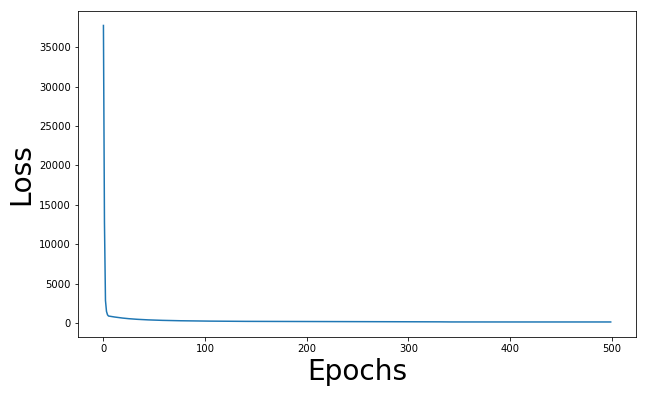

In [69]:
## Plotting loss function
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.xlabel('Epochs', fontsize = 28)
plt.ylabel('Loss', fontsize = 28)

In [40]:
# y_pred = model(X_test)
# y_pred_mean = (ymax - ymin)*(y_pred.components_distribution.mean() + ymin)
# y_pred_variance = y_pred.components_distribution.variance() 
# y_pred_std = (ymax - ymin)*(np.sqrt(y_pred_variance)+ ymin)
# y_test = (ymax - ymin)*(y_test + ymin)

In [41]:
y_pred = model(X_test)
y_pred_mean = y_pred.components_distribution.mean() 
y_pred_variance = y_pred.components_distribution.variance() 
y_pred_std = np.sqrt(y_pred_variance)
# y_test = (ymax - ymin)*(y_test + ymin)

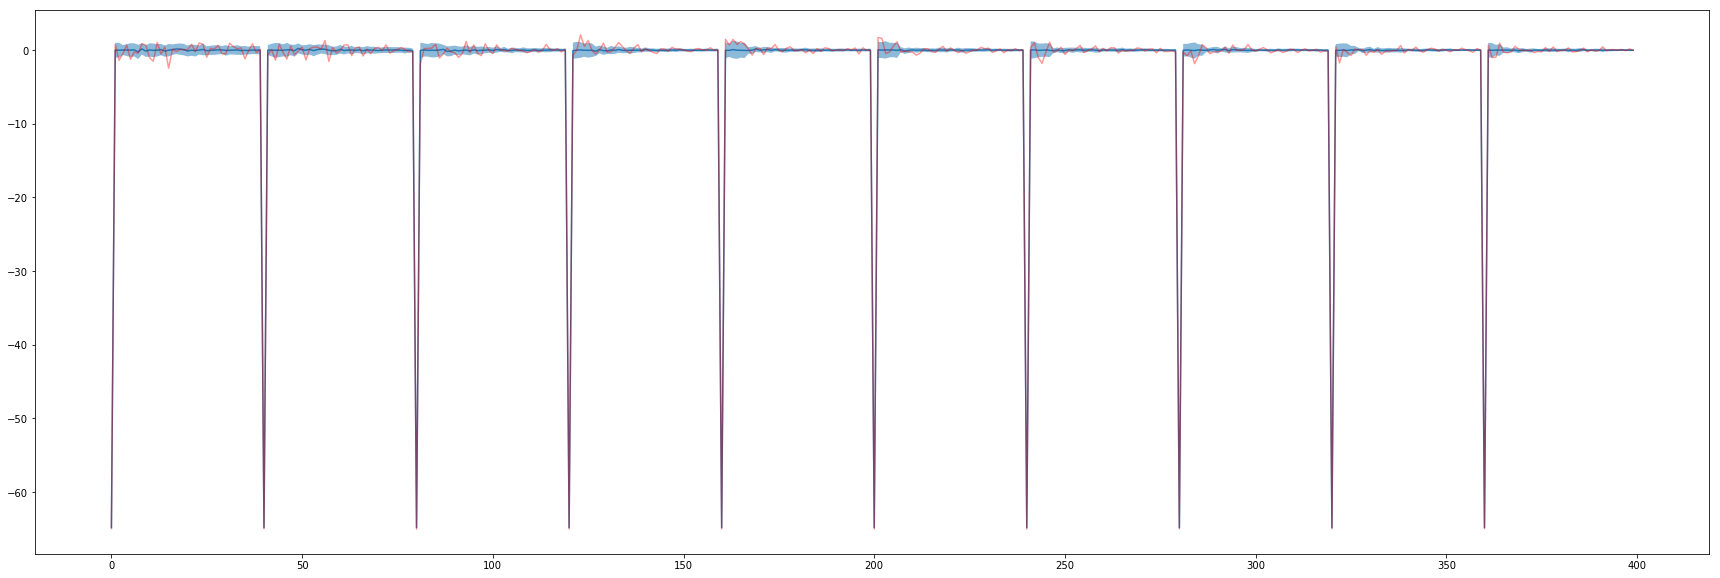

In [64]:
plt.figure(figsize = (30, 10))
x = np.arange(400)

idx_test = [2]

for idx in idx_test:
    
    plt.plot(x, y_pred_mean[idx, 0, :])
    plt.fill_between(x, y_pred_mean[idx, 0, :] - y_pred_std[idx, 0, :], y_pred_mean[idx, 0, :] + y_pred_std[idx, 0, :], alpha = 0.5)
    plt.plot(x, y_test[idx], 'r', alpha = 0.4)
# plt.yscale('symlog')
plt.show()


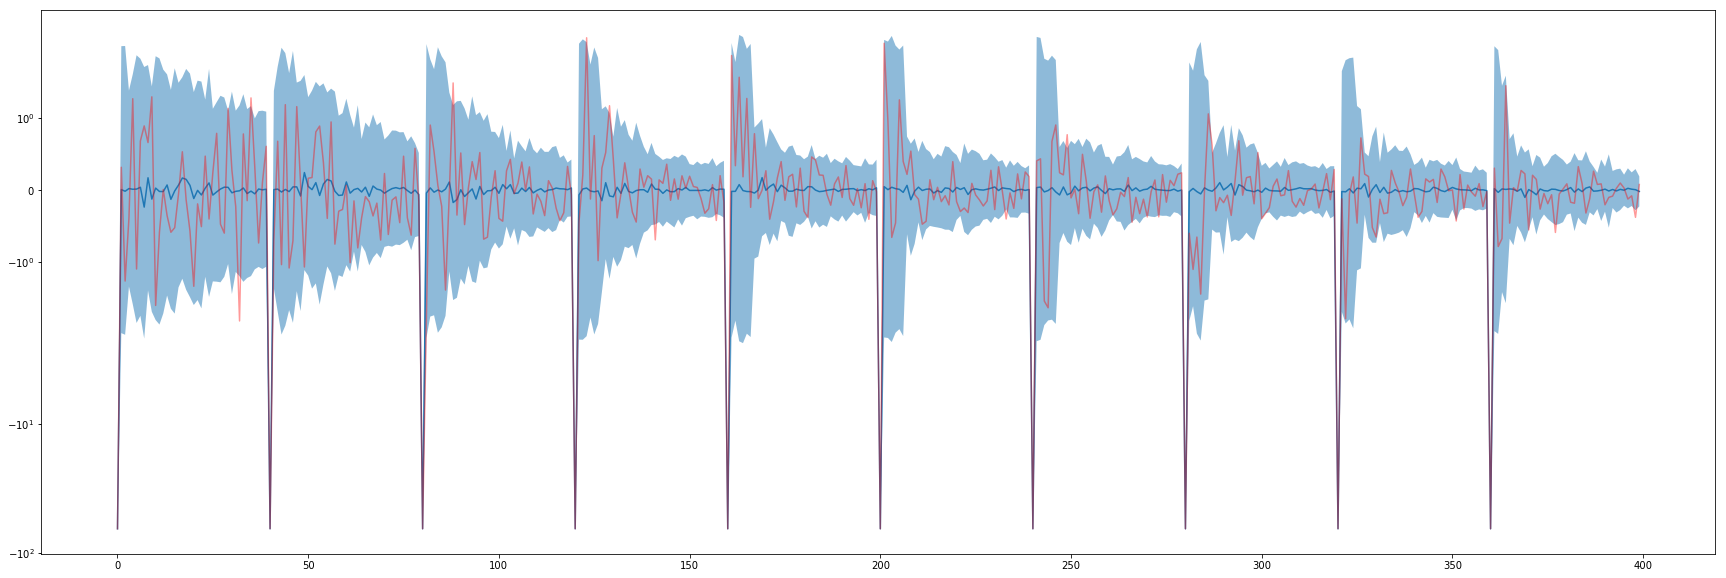

In [67]:
plt.figure(figsize = (30, 10))
x = np.arange(400)
plt.plot(x, y_pred_mean[0, 0, :])
plt.fill_between(x, y_pred_mean[0, 0, :] - 2*y_pred_std[0, 0, :], y_pred_mean[0, 0, :] + 2*y_pred_std[0, 0, :], alpha = 0.5)
plt.plot(x, y_test[0], 'r', alpha = 0.4)
plt.yscale('symlog')
plt.show()